In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Data import and pre-processing

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

/home/e/ermis/Storm_Eunice/stormeunice/lagrangian.py:171: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = mem_track.rolling(3, center=True).mean().vo.idxmax()
/home/e/ermis/Storm_Eunice/stormeunice/lagrangian.py:171: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = mem_track.rolling(3, center=True).mean().vo.idxmax()
/home/e/ermis/Storm_Eunice/stormeunice/lagrangian.py:171: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the

# Surface Lagrangians

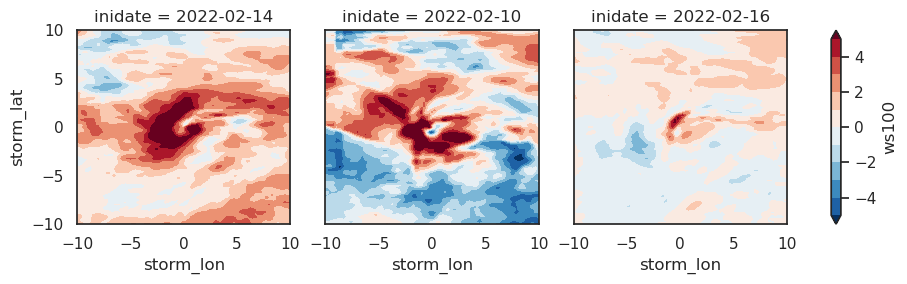

In [7]:
(incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

# Analysis of model spread

In [8]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

Text(55.4741481481481, 0.5, 'Initialisation date')

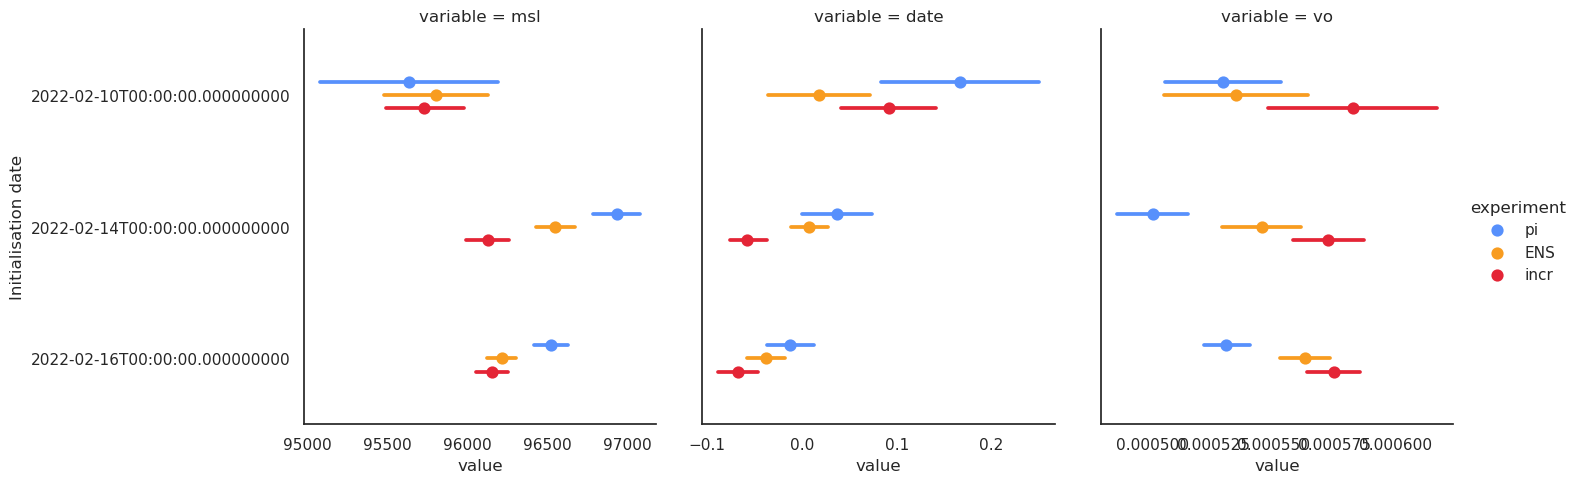

In [9]:
g = sns.catplot(data=ifs_eunice_list_stats.set_index(['experiment','inidate']).drop(['track_id','number'], axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'}, axis=1),
           x='value',
           col='variable',
           y='inidate',
           hue='experiment',
           hue_order=['pi','ENS','incr'],
           palette=get_palette.Petroff6().to_sn_palette(),
           kind='point',
           join=False,
           dodge=0.2,
           errorbar=('ci',66),
           n_boot=10000,
           sharex=False)

g.axes[0,0].set_ylabel('Initialisation date')
# inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
# g.axes[0,0].set_yticks(pd.to_datetime(inidates))
# g.axes[0,0].set_yticklabels(inidates)

In [24]:
# ifs_tracks_filtered
ifs_eunice_list.loc[ifs_eunice_list.groupby('track_id')['vo'].idxmax()]

/tmp/user/27529/ipykernel_2207368/1492398358.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ifs_eunice_list.loc[ifs_eunice_list.groupby('track_id').idxmax()]


ValueError: Cannot index with multidimensional key

In [9]:
ifs_eunice_list_stats

,experiment,inidate,number,track_id,msl,date,vo
0,ENS,2022-02-10,2,4,96089.23,0.125,0.000684
1,ENS,2022-02-10,7,5,95267.41,-0.125,0.000431
2,ENS,2022-02-10,8,8,94715.62,0.125,0.000578
3,ENS,2022-02-10,11,4,97218.59,0.125,0.000416
4,ENS,2022-02-10,12,4,96371.38,-0.125,0.000591
...,...,...,...,...,...,...,...
252,pi,2022-02-16,44,1,96530.89,0.000,0.000533
253,pi,2022-02-16,45,1,96188.36,0.000,0.000495
254,pi,2022-02-16,46,1,95782.28,-0.125,0.000464
255,pi,2022-02-16,48,1,95973.99,0.125,0.000510


In [10]:
def get_ws100_track(field, track):
    ws_df = field.ws100.rename({'timestep':'date'}).to_dataframe().reset_index()
    return pd.merge(track,ws_df, on=['inidate', 'date', 'number'])
    # ws = []
    # for idx in range(len(track)):
    #     ws.append(field.sel(timestep=track.date[idx], number=track.number[idx], inidate=track.inidate[idx]).ws100.max())
    # return track.assign(ws100=ws)
    

In [11]:
curr_storms.ws100.rename({'timestep':'date'}).to_dataframe().reset_index()

,inidate,experiment,number,date,storm_lat,storm_lon,ws100
0,2022-02-10,ENS,1,-2.0,-10.0,-10.00,NaN
1,2022-02-10,ENS,1,-2.0,-10.0,-9.75,NaN
2,2022-02-10,ENS,1,-2.0,-10.0,-9.50,NaN
3,2022-02-10,ENS,1,-2.0,-10.0,-9.25,NaN
4,2022-02-10,ENS,1,-2.0,-10.0,-9.00,NaN
...,...,...,...,...,...,...,...
34012219,2022-02-16,ENS,50,2.5,10.0,9.00,NaN
34012220,2022-02-16,ENS,50,2.5,10.0,9.25,NaN
34012221,2022-02-16,ENS,50,2.5,10.0,9.50,NaN
34012222,2022-02-16,ENS,50,2.5,10.0,9.75,NaN


In [15]:
ifs_eunice_list_stats.assign(ws100=lambda x: get_ws100_track(curr_storms, x))

ValueError: Cannot set a DataFrame with multiple columns to the single column ws100

In [16]:
len(ifs_eunice_list_stats)

257